In [1]:
import os
import re
from skimage.transform import resize, rotate
from skimage.morphology import disk, binary_dilation, skeletonize
from skimage.filters.rank import sum, mean
from skimage.filters import sobel_h, sobel_v, sobel, gaussian
from skimage.exposure import adjust_gamma
from skimage.color import gray2rgb, rgb2gray
from skimage.measure import regionprops
from scipy.spatial.distance import euclidean as distancia
import glob
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


ROOT = os.path.abspath('imgs')

lista_archivos = glob.glob(ROOT + '/*')
nombres_unicos = {re.findall(r'(\d+_\d+)', a)[0] for a in lista_archivos}
dict_archivos = {u: [a for a in lista_archivos if os.path.basename(a).startswith(u)] for u in nombres_unicos}

In [2]:
## Funciones
def abrir_img(path, shape=None):
    img = PIL.Image.open(path)
    if shape is not None:
        img = img.resize(shape)
    return np.array(img)

def adjust(img):
    im = 0.8*img[...,1]+0.2*img[...,2]
    def gauss(v, u, sigma = 200):
        return np.exp(-(v-u)**2/(2*sigma**2))
    x = np.arange(im.shape[1])
    y = np.arange(im.shape[0])
    X, Y = np.meshgrid(x,y)
    Z = gauss(X, im.shape[1]//2) + gauss(Y, im.shape[0]//2)
    adjusted = im*Z
    return adjusted / np.max(adjusted)

def get_optical_disk_center(im, t=0.92, scale=0.3): 
    if scale!=1:
        shape_scaled = [int(s*scale) for s in im.shape[:2]]
        im = resize(im, shape_scaled, anti_aliasing=True)
    im = adjust(im)
    im_bin = im > t
    im_bin = binary_dilation(im_bin, disk(10))
    regions = regionprops(im_bin*1)
    return [int(v/scale) for v in regions[0].centroid]# cy, cx

def draw_arrows(dx, dy, ax, s=2.3):
    kwargs = {
        'width' : 0.05
    }
    for i in range(dx.shape[0]):
        for x in range(dx.shape[1]):
            y = i
            ax.arrow(x,y, dx[i,x]*s, dy[i,x]*s,
                    **kwargs)
            
def extraer_region(img, cy, cx, long=21):
    assert min(img.shape)>=10
    max_y = img.shape[1]
    x0 = cx-long//2
    y0 = min(cy-long//2, max_y-long)
    return img[y0:y0+long,
               x0:x0+long]

def calcular_angulo(reg, show=False):
    dy = sobel_h(reg)
    dx = sobel_v(reg)
    angs = np.abs(np.tan(dy/dx)*180/np.pi)
    angs = angs[angs<=90]
    if show:
        fig, ax = plt.subplots(1,2, figsize=(10,7))
        ax[0].imshow(reg)
        ax[1].imshow(reg)
        draw_arrows(dx,dy, ax[1])
        plt.title(f'{np.nanmean(angs)}')
        plt.show()
    return(np.nanmean(angs))

def encontrar_rotacion(reg, show=False):
    """
    Búsqueda exhaustiva del ángulo óptimo para realizar la rotación
    """
    x = np.linspace(-120,120, 100)
    y = [abs(calcular_angulo(rotate(reg, i))) for i in x]
    if show:
        plt.plot(x,y)
        plt.show()
    ordenados = sorted(zip(np.abs(x),y, np.arange(len(x))), key = lambda x: x[1])
    x_min = ordenados[0]
    x_cont=1
    while x_cont<10:
        if ordenados[x_cont][0] < x_min[0]:
            x_min = ordenados[x_cont]
        else:
            break
    return x[x_min[-1]]

class Grafica(nx.Graph):
    def __init__(self, **attrs):
        super().__init__(**attrs)
        self.diGraph = None
        self.img_shape = None
        self.puntos_iniciales = []
        self.cdo = None

    def armar_grafica(self, skl, clase=None):
        """
        Recibe la imagen del esqueleto y devuelve un objeto
        Graph con la representación gráfica de este
        """
        self.img_shape = skl.shape
        self.cdo = [i//2 for i in self.img_shape]

        pixels = list(zip(*np.where(skl)))
        self.add_nodes_from(pixels, clase=clase)
        for cy,cx in pixels:
            cymin, cxmin = max(cy, 1), max(cx,1)
            neigh = skl[cymin-1:cy+2, cxmin-1:cx+2]
            
            n_coords = [(cymin+y-1, cxmin+x-1) for y,x in zip(*np.where(neigh))]      
            #print((cy, cx), n_coords,neigh)      
            for y,x in n_coords:
                if (y,x)!=(cy,cx):
                    self.add_edge((y,x), (cy,cx))
                        
    def buscar_puntos(self):
        """
        Busca y devuelve dos tipos de nodos:
          intersecciones -- tienen un grado igual o mayor a 3
          puntos finales -- tienen un grado igual a 1
        """
        intersecs = []
        end_points = []
        for k,v in self.degree:
            if v==1:
                end_points.append(k)
            elif v>=3:
                intersecs.append(k)
        return(intersecs, end_points)
    
    def mostrar(self, plot_ax=None, tipo='puntos' , dirigido=False, **plotargs):
        """
        Muestra una representación visual de la gráfica en dos posibles tipos:
          'nodos' --- Muestra los nodos y cómo están conectados. Para este caso
                      se puede especificar si graficar la versión dirigida
          'puntos' -- Muestra una imagen binaria de los nodos como puntos.
        """
        assert tipo in ['puntos', 'nodos'], 'Seleccionar un tipo válido'

        if plot_ax is None:
            fig, ax = plt.subplots(**plotargs)
        else:
            ax = plot_ax
        if not ax.yaxis_inverted() and tipo=='puntos':
            ax.invert_yaxis()
            
        if tipo == 'nodos':
            g = self.diGraph if dirigido and self.diGraph is not None else self
            positions = {n:(n[1], 6-n[0]) for n in g.nodes}
            nx.draw(g, pos=positions, ax=ax)
        else:
            y,x = list(zip(*self.nodes))
            ax.plot(x,y,'k.', ms=1)
        if plot_ax is None:
            plt.show()

    def a_digraph(self, do_pts=None):
        """
        Devuelve una gráfica dirigida de una gráfica G, partiendo desde
        los puntos cercanos al DO. Si no se proporcionan los puntos, se
        buscan a partir del centro de la imagen.
        """
        if do_pts is None:
            _center = [i//2 for i in self.img_shape]
            do_pts = self.selec_puntos_do(_center, int(min(_center)*0.8))

        self.puntos_iniciales = do_pts
        self.diGraph = nx.DiGraph()

        edges = []
        for p in do_pts:
            n1, ln2 = p, [n for n in self[p] if n!=p]
            for n2 in ln2:
                edges += self.recorrer_todo_a_aristas([n1,n2])
        self.diGraph.add_edges_from(edges, clase=None)

        return self.diGraph

    def recorrer_todo_a_aristas(self, visitados, aristas=None):
            """
            Recorre la gráfica desde el último punto visitado
            y devuelve la lista de adjacencia.
            Recibe una lista de elementos visitados, cuya longitud mínima
            debe ser == 2
            """
            if aristas is None:
                aristas = [tuple(visitados)]
            actual = visitados[-1]
            neigh = [n for n in self[actual] if n not in visitados]
            for n in neigh:
                aristas.append((actual, n))
                visitados.append(n)
                self.recorrer_todo_a_aristas(visitados, aristas)
            return aristas

    def recorrer_rama(self, n):
        """
        Recorre la rama de una gráfica dirigida, comenzando desde el nodo n.
        Se detiene al encontrarse con una bifurcación o al final de la rama.
        Devuelve una lista con los nodos recorridos y otra con los
        nodos siguientes de la bifurcación.
        """
        nodos = [n]
        while True:
            sigs = list(self.diGraph.succ[n])
            if len(sigs) == 1:
                nodos.append(sigs[0])
                n = sigs[0]
            else:
                break
        return nodos, sigs

    def limpiar_ramas(self, long_min, pts = None):
        """
        Recibe la gráfica dirigida y los puntos iniciales para hacer el recorrido de todo
        el árbol y eliminar todas aquellas ramificaciones menores a long_min.
        """
        if pts is None:
            pts = self.puntos_iniciales
        if self.diGraph is None:
            raise Exception('Solo funciona con gráficas dirigidas. Hazla dirigida con self.a_digraph')
        por_eliminar = []
        restantes = pts[:]
        while len(restantes)!=0:
            siguiente = restantes.pop()
            nodos, por_revisar = self.recorrer_rama(siguiente)
            if len(nodos)< long_min and len(por_revisar)==0:
                por_eliminar += nodos
            restantes += por_revisar
        self.remove_nodes_from(por_eliminar)
        self.diGraph.remove_nodes_from(por_eliminar)

        ## Se seleccionan los nuevos puntos iniciales, por si cambiaron: 
        self.puntos_iniciales = self.selec_puntos_do()
        return(por_eliminar)

    def selec_puntos_do(self, cdo=None, umbral0 = 300):
        """
        Busca los puntos finales más cercanos centro del Disco Óptico (dco).
        Elimina todos aquellos que se encuentren más lejanos y 
        que tengan conexión con otro punto.
        """
        if cdo is None:
            cdo = self.cdo
        _, pts = self.buscar_puntos()
        aprox1 = [p for p in pts if distancia(p, cdo)<umbral0]
        self.cdo = ajustar_cdo(aprox1)
        ##Prueba exhaustiva para eliminar nodos que no sean los
        ## más cercanos al DO y que no pertenezcan a la misma rama
        mejores = set()
        for p1 in pts:
            mejor = p1
            for p2 in pts:
                if nx.has_path(self, mejor, p2):
                    mejor = sorted((mejor, p2), key=lambda x: distancia(x, (self.cdo)))[0]
            mejores.add(mejor)
        return list(mejores)

def dibujar_puntos(ax, pts, stl='w*'):
    y, x = list(zip(*pts))
    ax.plot(x,y, stl)
    
def ajustar_cdo(pts): #Ajustar el centro del disco óptico
    y, x = list(zip(*pts))
    new_x = np.mean(x)
    new_y = np.mean(y)
    return new_y, new_x

"""
#                 0 1 2 3 4 5 6
esqu = np.array([[1,1,1,1,0,1,0],#0
                 [0,0,0,0,1,0,1],#1
                 [0,1,0,0,1,0,1],#2
                 [1,0,0,0,0,0,0],#3
                 [1,0,1,0,1,0,1],#4
                 [1,0,1,0,1,0,1],#5
                 [0,1,0,1,0,1,0]])#6
g = Grafica()
g.armar_grafica(esqu)
g.a_digraph([(0,0), (6,5)])
g.mostrar(tipo='puntos', dirigido=False)
g.limpiar_ramas(2)
g.mostrar(tipo='nodos', dirigido=True)
""";

In [35]:
#np.random.seed(12)

X_data = []
Y_data = []
ventana = 250
padding = 0
for n, k in enumerate(list(dict_archivos.keys())[:1]):#enumerate(dict_archivos):#
    print(f'Abriendo imagen {n+1} ({k})')
    labels = []
    for i in dict_archivos[k]:
        if 'artery' in i: #Máscara de arterias
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= np.pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.insert(0, b)
        elif 'vein' in i: #Máscara de venas
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= np.pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.append(b)
        else:
            img = abrir_img(i)/255.
            img = np.pad(img,((padding,padding),(padding,padding), (0,0)), mode='constant', constant_values=0)
    
    #Se buscan las coordenadas donde hay vasos sanguíneos
    print('\t- Buscando el disco óptico...', end=' ')
    doy, dox = get_optical_disk_center(img)
    print(f' Encontrado en {(doy,dox)}')
    print('\t- Buscando las coordenadas válidas de búsqueda...')
    mask = (labels[0] + labels[1])/2.>0.1
    esqueleto = skeletonize(mask)
    coords = list(zip(*np.where(esqueleto)))
    np.random.shuffle(coords)
    G = Grafica()
    G.armar_grafica(esqueleto)
    
    


Abriendo imagen 1 (1_000)
	- Buscando el disco óptico...  Encontrado en (1995, 1324)
	- Buscando las coordenadas válidas de búsqueda...
46843


In [72]:
do_vent = 1000
preds = np.zeros([do_vent, do_vent]+[3])
new_labels = [mask] + labels
for l in range(3):
    preds[...,l] = new_labels[l][doy-do_vent//2:doy+do_vent//2,
                                 dox-do_vent//2:dox+do_vent//2]

gven, gart = Grafica(), Grafica()

gart.armar_grafica(skeletonize(preds[..., 1]))
gven.armar_grafica(skeletonize(preds[..., 2]))

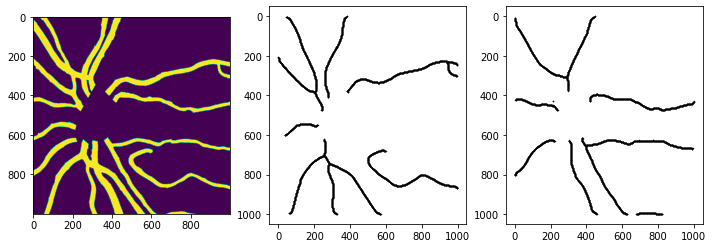

In [73]:
gart.a_digraph()
gven.a_digraph()
gart.limpiar_ramas(40)
gven.limpiar_ramas(40)


f, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(preds[..., 0])
gart.mostrar(plot_ax=axs[1])
gven.mostrar(plot_ax=axs[2])
plt.show()

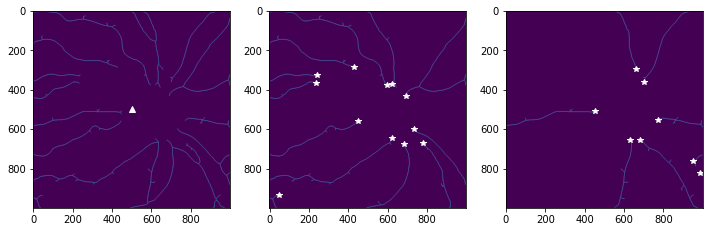

In [12]:
do_art_pts = gart.selec_puntos_do((500,500))
do_ven_pts = gven.selec_puntos_do((500,500))

f, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(skeletonize(preds[..., 0]))
ax[0].plot([500], [500], 'w^')
ax[1].imshow(skeletonize(preds[..., 1]))
dibujar_puntos(ax[1], do_art_pts)
ax[2].imshow(skeletonize(preds[..., 2]))
dibujar_puntos(ax[2], do_ven_pts)
plt.show()

In [ ]:
gart.a_digraph()
gven.a_digraph()
